In [1]:
import pandas as pd
import utils
import plotly.io as pio
from plotly.io import show
import numpy as np

import matplotlib.pyplot as plt

from skfolio import Population, RiskMeasure, Portfolio
from skfolio.model_selection import cross_val_predict, CombinatorialPurgedCV
from skfolio.optimization import (
    MeanRisk,
    ObjectiveFunction,
    EqualWeighted,
    InverseVolatility,
    RiskBudgeting
)

# Fetch Data


In [38]:
tickers = [
    "NTPC",
    "ONGC",
    "HAL",
    "RITES",
    "APARINDS",
    "LICI",
    "TITAN",
    "SUNPHARMA",
    "TEGA",
    "NHPC",
    "ENGINERSIN",
    "BEL",
    "HDFCAMC",
    "VBL",
    "COALINDIA",
    "LT",
    "CGPOWER",
    "ABB",
]

In [39]:
ret = utils.get_multiple_returns(tickers)
ret

,NTPC,ONGC,HAL,RITES,APARINDS,LICI,TITAN,SUNPHARMA,TEGA,NHPC,ENGINERSIN,BEL,HDFCAMC,VBL,COALINDIA,LT,CGPOWER,ABB
Date,,,,,,,,,,,,,,,,,,
2022-05-18,-0.013289,0.000306,0.005593,-0.003764,-0.018387,0.001257,-0.004411,0.008298,-0.030334,-0.025836,-0.004971,0.001504,-0.020040,-0.006037,0.005419,-0.019700,0.049020,-0.006690
2022-05-19,-0.003367,-0.019608,0.002826,-0.019487,0.015901,-0.040509,-0.025291,-0.016182,-0.007792,-0.009360,-0.019151,-0.024024,-0.038505,-0.038116,-0.023444,-0.015612,-0.027188,-0.001733
2022-05-20,0.010811,0.011875,0.042385,0.018455,0.032697,-0.017482,0.011885,0.035101,0.049813,0.007874,0.009338,0.032747,0.000029,0.039768,0.026214,0.040150,0.002620,0.006198
2022-05-23,0.003676,-0.042001,0.033349,0.006173,-0.029757,-0.011257,0.006668,0.006990,-0.003126,0.012500,0.003364,-0.015110,0.016669,-0.022024,-0.008873,0.021148,0.023229,0.003451
2022-05-24,-0.021645,-0.028691,-0.017155,0.002375,0.013740,0.007651,-0.005136,-0.013177,-0.018703,0.023148,-0.002515,0.001080,-0.018960,0.027802,-0.010581,-0.010857,-0.025255,-0.006073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,0.012963,0.009212,0.039782,0.006792,0.021103,0.004716,-0.006400,0.000741,0.011627,0.005571,0.030566,0.009174,0.004018,0.009889,0.006577,0.006842,0.020874,0.005771
2024-04-25,0.021470,0.009307,0.013695,0.017496,0.003150,-0.006308,-0.010707,0.023153,0.010367,0.008864,0.037132,0.004651,0.007431,-0.002180,0.019376,0.004801,-0.005593,0.013848
2024-04-26,-0.008909,0.003369,-0.004087,0.012386,-0.031431,0.003606,0.003836,-0.008946,-0.009113,0.016474,0.066652,0.005682,0.008162,0.012310,0.007404,-0.012896,0.028308,-0.003304


In [40]:
nse = utils.get_returns("^NSEI", index=True)
nse.index = nse["Date"]
nse = nse.drop(columns=["Date"]).loc[ret.index[0] :]
nse

,^NSEI
Date,
2022-05-18,-0.001169
2022-05-19,-0.026533
2022-05-20,0.028891
2022-05-23,-0.003163
2022-05-24,-0.005523
...,...
2024-04-26,-0.006664
2024-04-29,0.009967
2024-04-30,-0.001703


# Models


### Sharpe Ratio Maximization


In [41]:
sharpe_model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    portfolio_params=dict(name="Max Sharpe"),
)
sharpe_pred = sharpe_model.fit_predict(ret)
sharpe_pred.annualized_sharpe_ratio

4.949485197618665

### Minimum Variance


In [42]:
inv_var_model = InverseVolatility(portfolio_params=dict(name="Minimum Variance"))
inv_var_pred = inv_var_model.fit_predict(ret)
inv_var_pred.annualized_sharpe_ratio

3.932628263238126

### Minimum CVaR

In [43]:
cvar_model = RiskBudgeting(risk_measure=RiskMeasure.CVAR, portfolio_params=dict(name="Minimum CVaR"))
cvar_pred = cvar_model.fit_predict(ret)
cvar_pred.annualized_sharpe_ratio

4.345994702929284

### NIFTY50 Benchmark


In [44]:
benchmark = EqualWeighted(portfolio_params=dict(name="NIFTY50"))
bench_pred = benchmark.fit_predict(nse)
bench_pred.annualized_sharpe_ratio

1.4824829024255346

### Clustering Optimization


In [45]:
import skfolio.optimization as opt

inner_estimator = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
)
outer_estimator = opt.RiskBudgeting(risk_measure=RiskMeasure.CVAR)

cluster_model = opt.NestedClustersOptimization(
    inner_estimator=inner_estimator,
    outer_estimator=outer_estimator,
    n_jobs=-1,
    portfolio_params=dict(name="NCO-1"),
)
cluster_pred = cluster_model.fit_predict(ret)
cluster_pred.annualized_sharpe_ratio

4.7115961998049025

### Rolling Window Optimization


In [46]:
#rolling_pred = utils.rolling_window_portfolio(ret, 5)

In [47]:
population = Population(
    [cluster_pred, sharpe_pred, inv_var_pred, cvar_pred, bench_pred]
)
population.set_portfolio_params(compounded=True)
population.plot_composition()

In [48]:
population.plot_cumulative_returns()

In [49]:
summary = population.summary()
summary#[summary.index.str.contains("Annualized")]

,NCO-1,Max Sharpe,Minimum Variance,Minimum CVaR,NIFTY50
Mean,0.28%,0.29%,0.22%,0.23%,0.070%
Annualized Mean,70.04%,72.53%,56.25%,57.96%,17.60%
Variance,0.0088%,0.0085%,0.0081%,0.0071%,0.0056%
Annualized Variance,2.21%,2.15%,2.05%,1.78%,1.41%
Semi-Variance,0.0044%,0.0042%,0.0047%,0.0039%,0.0030%
Annualized Semi-Variance,1.12%,1.07%,1.19%,0.97%,0.75%
Standard Deviation,0.94%,0.92%,0.90%,0.84%,0.75%
Annualized Standard Deviation,14.86%,14.65%,14.30%,13.34%,11.87%
Semi-Deviation,0.67%,0.65%,0.69%,0.62%,0.54%
Annualized Semi-Deviation,10.57%,10.33%,10.90%,9.87%,8.63%


In [50]:
population.composition() * 1_00_000

,NCO-1,Max Sharpe,Minimum Variance,Minimum CVaR,NIFTY50
asset,,,,,
CGPOWER,17114.369903,12656.729210,4919.496677,5448.479646,0.0
TEGA,14347.080605,11006.470843,4573.727323,9157.968035,0.0
VBL,9890.704491,10059.126654,4668.819884,7298.547125,0.0
APARINDS,8736.961121,12343.595385,3078.323499,5279.778427,0.0
NTPC,8392.384261,6440.259178,7031.313621,4701.665102,0.0
COALINDIA,7458.882978,4567.775553,6217.220566,4220.664173,0.0
LT,7379.421158,3677.181418,7630.868141,7139.907871,0.0
SUNPHARMA,6970.184284,20158.870030,8844.207289,15271.076953,0.0
HAL,5290.690750,14719.138584,5180.754649,3925.418497,0.0


In [51]:
comp = population.composition()
comp['Minimum CVaR']

asset
CGPOWER       0.054485
TEGA          0.091580
VBL           0.072985
APARINDS      0.052798
NTPC          0.047017
COALINDIA     0.042207
LT            0.071399
SUNPHARMA     0.152711
HAL           0.039254
ABB           0.047174
HDFCAMC       0.049521
BEL           0.036376
NHPC          0.028576
ENGINERSIN    0.022278
RITES         0.027030
TITAN         0.075299
ONGC          0.055862
LICI          0.033449
^NSEI         0.000000
Name: Minimum CVaR, dtype: float64

<Axes: >

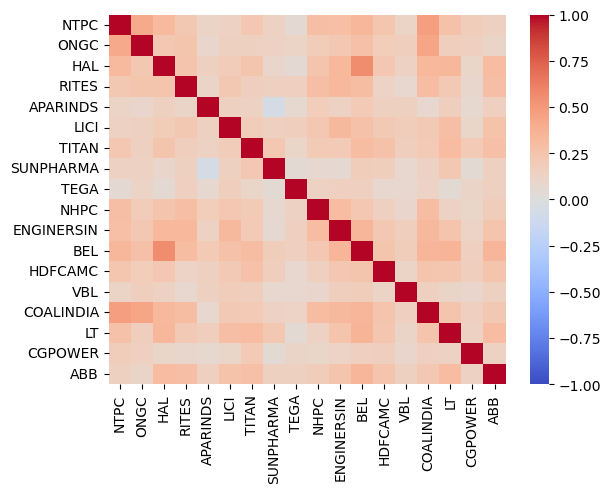

In [53]:
import seaborn as sns

sns.heatmap(ret.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1)